# Phase III: First ML Proof of Concept (5\%)

### Team Names:
- Luc
- Nora
- Kevin
- Thomas
- Zijiang Yang

In [1]:
# Importing all useful libraries (for webscraping and ML as well)
import os
import pandas as pd
import numpy as np
import requests
import time
from io import BytesIO

In [2]:
# webscraping
api_key = "03bcc17f7d105b13199e0325b659d4ab"
API_KEY = "6c30ec8965840313bb630941ccabc149"
BASE_URL = "https://api.themoviedb.org/3"

# Function to get movie details by ID
def get_movie_details(movie_id):
    """
    Gets the movie details of a movie through a movie id.

    Args:
        movie_id (string): the id of the movie as a string.
    
    Returns:
        response: the reponse (as a json) recieved.
    """
    url = f"{BASE_URL}/movie/{movie_id}?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching details for movie ID {movie_id}: {response.status_code}")
        return None

# Function to get movie credits by ID
def get_movie_credits(movie_id):
    """
    Gets the movie credits of a movie through a movie id.

    Args:
        movie_id (string): the id of the movie as a string.
    
    Returns:
        response: the reponse (as a json) recieved.
    """
    url = f"{BASE_URL}/movie/{movie_id}/credits?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching credits for movie ID {movie_id}: {response.status_code}")
        return None

# Function to get actor popularity by ID
def get_actor_popularity(actor_id):
    """
    Gets the popularity of an actor through an actor id.

    Args:
        actor_id (string): the id of the actor as a string.
    
    Returns:
        response: the popularity of the actor.
    """
    url = f"{BASE_URL}/person/{actor_id}?api_key={API_KEY}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        return data.get('popularity')
    else:
      print(f"Error fetching popularity for actor ID {actor_id}: {response.status_code}")
      return None

page = 1
df = pd.DataFrame()
for i in range(50): #the number of pages to go up until
    url = f"{BASE_URL}/movie/top_rated?api_key={api_key}&language=en-US&page={page}"

    response = requests.get(url)
    data = response.json()

    new_data = pd.DataFrame(data['results'])

    df = pd.concat([df, new_data])
    page += 1

# Filter out movies with vote count less than 1000
df = df[df['vote_count'] >= 1000].copy() # Use .copy() to avoid SettingWithCopyWarning

# Add budget information
df['budget'] = None
for index, row in df.iterrows():
    movie_id = row['id']
    details = get_movie_details(movie_id)
    if details and 'budget' in details:
        df.loc[index, 'budget'] = details['budget']
    time.sleep(0.05) # Add a small delay to avoid hitting API limits

# Add top actor popularity
df['top_actor_popularity (out of 10)'] = None # Initialize top_actor_popularity column
for index, row in df.iterrows():
    movie_id = row['id']
    credits = get_movie_credits(movie_id)
    if credits and 'cast' in credits and len(credits['cast']) > 0:
        top_actor_id = credits['cast'][0]['id']
        actor_popularity = get_actor_popularity(top_actor_id)
        df.loc[index, 'top_actor_popularity (out of 10)'] = actor_popularity
    time.sleep(0.05) # Add a small delay to avoid hitting API limits


# Convertin budget to millions n dropping orginal budget column
df['budget_in_millions'] = df['budget'] / 1000000
df = df.drop(columns=['budget'])

df.head()

,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,release_date,title,video,vote_average,vote_count,top_actor_popularity (out of 10),budget_in_millions
0,False,/zfbjgQE1uSd9wiPTX4VzsLi0rGG.jpg,"[18, 80]",278,en,The Shawshank Redemption,Imprisoned in the 1940s for the double murder ...,25.0715,/9cqNxx0GxF0bflZmeSMuL5tnGzr.jpg,1994-09-23,The Shawshank Redemption,False,8.711,29228,0.452,7.275
1,False,/tmU7GeKVybMWFButWEGl2M4GeiP.jpg,"[18, 80]",238,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",21.6694,/3bhkrj58Vtu7enYsRolD1fZdja1.jpg,1972-03-14,The Godfather,False,8.684,22071,2.2514,2.5
2,False,/kGzFbGhp99zva6oZODW5atUtnqi.jpg,"[18, 80]",240,en,The Godfather Part II,In the continuing saga of the Corleone crime f...,12.2619,/ecBRkXerAZqRRUfR8Lt3L3Dh6J5.jpg,1974-12-20,The Godfather Part II,False,8.571,13340,3.3393,0.0
3,False,/zb6fM1CX41D9rF9hdgclu0peUmy.jpg,"[18, 36, 10752]",424,en,Schindler's List,The true story of how businessman Oskar Schind...,10.4613,/sF1U4EUQS8YHUYjNl3pMGNIQyr0.jpg,1993-12-15,Schindler's List,False,8.566,16863,0.5835,15.0
4,False,/w4bTBXcqXc2TUyS5Fc4h67uWbPn.jpg,[18],389,en,12 Angry Men,The defense and the prosecution have rested an...,8.8201,/ow3wq89wM8qd5X7hWKxiRfsFf9C.jpg,1957-04-10,12 Angry Men,False,8.549,9531,0.3382,0.0


In [3]:
#clean data
def get_languages():
    """
    This function gets the list of movie languages from the TMDB.
    
    Returns:
        response (dict): The list of languages as a dictionary.
    """
    url = "https://api.themoviedb.org/3/configuration/languages"
    params = {"api_key": api_key}
    headers = {"accept": "application/json"}

    response = requests.get(url, headers=headers, params=params)
    return response.json()

def get_movie_genres():
    """
    This funciton gets the list of movie genres from the TMDB.
    
    Returns:
        response (dict): The list of genres as a dictionary.
    """
    url = "https://api.themoviedb.org/3/genre/movie/list?language=en"
    params = {"api_key": api_key}
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers, params=params)

    return response.json()

def clean_data(df):
    """
    Cleans the data given into these metrics: 
        - id
        - title
        - popularity
        - rating
        - number_of_raters
        - top_actor_popularity (out of 10)
        - budget_in_millions
        - release_year
        - release_month
        - release_day 
        - original language (as dummy variables in int (1) format)
        - genres (as dummy variables in int (1) format)

    Args:
        df (DataFrame): the inputted dataframe to be cleaned.

    Returns:
        cleaned_df (DataFrame): a cleaned dataframe.
    """
    
    #get the list of languages from TMDB
    languages_dict = get_languages()
    languages = {}
    for lang in languages_dict:
        languages[lang['iso_639_1']] = lang['english_name']
    
    #get the list of genres from TMDB
    genres_dict = get_movie_genres()
    genre_list = {}
    for genre in genres_dict['genres']:
        genre_list[genre['id']] = genre['name']

    #initialize lists to hold data
    movie_ids = []
    movie_titles = []
    movie_year = []
    movie_month = []
    movie_day = []
    movie_language = []
    movie_popularity = []
    movie_genres = []
    movie_vote_average = []
    movie_vote_count = []
    movie_budget = []
    movie_top_actor_popularity = []

    #loop through all rows of the data
    for data in df.iterrows():
        movie = data[1]

        movie_ids.append(movie['id']) #append movie id

        movie_titles.append(movie['title']) #append movie title

        #append movie release date
        movie_year.append(int(movie['release_date'][0:4])) 
        movie_month.append(int(movie['release_date'][5:7]))
        movie_day.append(int(movie['release_date'][8:10]))

        movie_language.append(languages[movie['original_language']]) #append movie language

        movie_popularity.append(float(movie['popularity'])) #append movie popularity

        #append movie genres as a list of genres
        genres = movie['genre_ids']
        list_of_genres = []
        for index in genres:
            list_of_genres.append(genre_list[index])
        movie_genres.append(list_of_genres)

        #append movie rating average and count
        movie_vote_average.append(float(movie['vote_average']))
        movie_vote_count.append(int(movie['vote_count']))

        movie_budget.append(round(float(movie['budget_in_millions']), 3)) #append movie budget in millions (rounded to 3 decimal places)

        movie_top_actor_popularity.append(movie['top_actor_popularity (out of 10)']) #append top actor popularity

    #put all of the lists into a dictionary
    df_dict = {'movie_id': movie_ids,
               'title': movie_titles,
               'popularity': movie_popularity,
               'rating': movie_vote_average,
               'number_of_raters': movie_vote_count,
               'top_actor_popularity (out of 10)': movie_top_actor_popularity,
               'budget_in_millions': movie_budget,
               'genres': movie_genres,
               'release_year': movie_year,
               'release_month': movie_month,
               'release_day': movie_day,
               'original_language': movie_language,
               }

    cleaned_df = pd.DataFrame(df_dict) #create the dataframe

    #make dummy variables for categorical data
    cleaned_df = pd.get_dummies(cleaned_df, columns=['original_language'], dtype='int')

    df_exploded = cleaned_df.explode('genres') #explode the genres column so each genre has its own row (we'll remove these extra rows later)
    df_genre_dummies = pd.get_dummies(df_exploded['genres']) #get the dummy variables for the genres
    cleaned_df = cleaned_df.join(df_genre_dummies.groupby(df_exploded.index).sum()) #put rows back together again

    cleaned_df = cleaned_df.drop(columns=['genres']) #drop the genres column now, as we don't need it

    cleaned_df = cleaned_df.sort_values(by='movie_id') #sort the dataframe by movie_id (this isn't really necessary)
    return cleaned_df.reset_index(drop=True) #return the dataframe, and reset the index of the rows

In [4]:
# Print first 50 rows of cleaned data
cleaned_df = clean_data(df)
cleaned_df

,movie_id,title,popularity,rating,number_of_raters,top_actor_popularity (out of 10),budget_in_millions,release_year,release_month,release_day,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,11,Star Wars,14.0042,8.204,21652,3.4353,350.000,1977,5,25,...,0,0,0,0,0,1,0,0,0,0
1,12,Finding Nemo,13.4401,7.817,20051,3.0610,81.000,2003,5,30,...,0,0,0,0,0,0,0,0,0,0
2,13,Forrest Gump,17.4205,8.463,28860,4.1264,200.000,1994,6,23,...,0,0,0,0,1,0,0,0,0,0
3,14,American Beauty,6.1478,8.003,12643,4.2883,0.000,1999,9,15,...,0,0,0,0,0,0,0,0,0,0
4,15,Citizen Kane,4.3718,7.999,5812,0.3382,0.000,1941,4,17,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,1026227,There's Still Tomorrow,2.1686,8.100,1440,0.4520,7.275,2023,10,26,...,1,0,0,0,0,0,0,0,0,0
613,1062722,Frankenstein,485.1768,7.800,1587,0.4296,0.531,2025,10,17,...,0,1,0,0,0,0,0,0,0,0
614,1084736,The Count of Monte Cristo,10.5834,7.954,1820,0.9464,1.800,2024,6,28,...,0,0,0,0,0,0,0,0,0,0
615,1087192,How to Train Your Dragon,38.1105,7.999,2188,3.3393,0.000,2025,6,6,...,0,0,0,0,0,0,0,0,0,0


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, shapiro
import numpy as np

### Attempt 1 - Linear Regression

Model 1: Budget vs. Rating
Budget vs. Rating Model - Mean Squared Error: 0.05755874800710176
Budget vs. Rating Model - R2: -0.01720908945762245


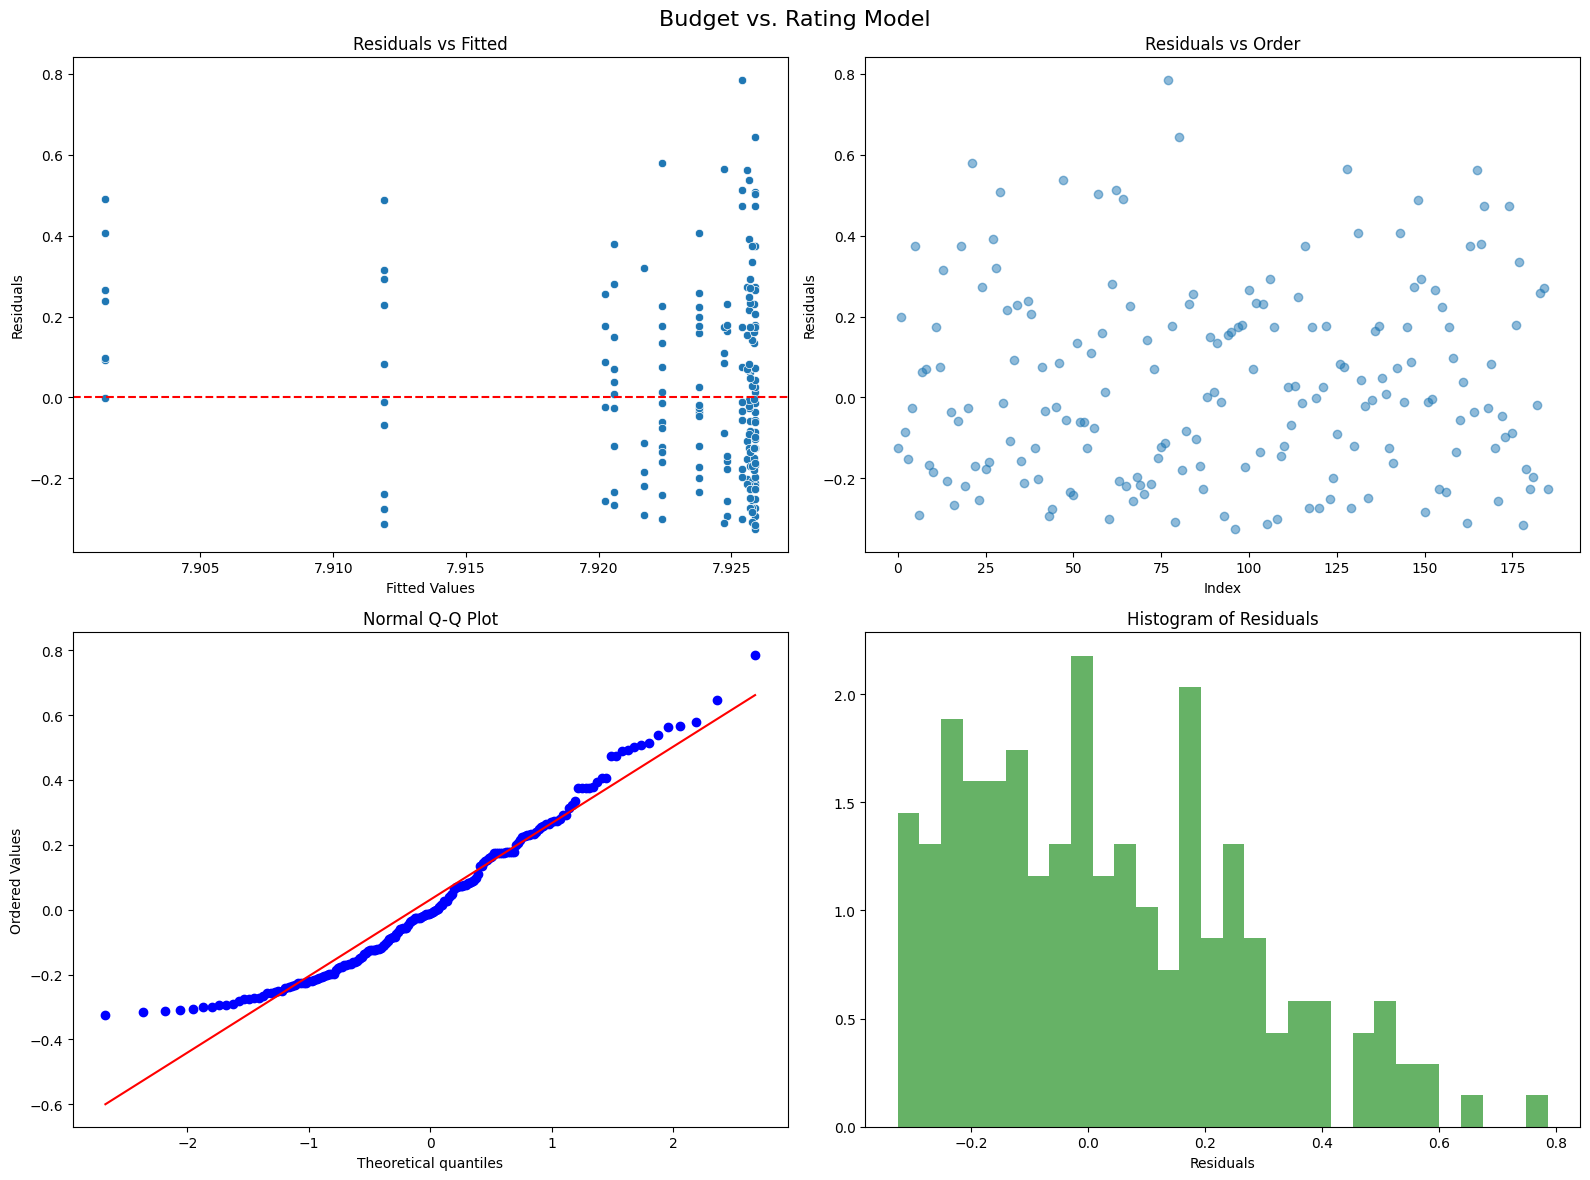


Model 2: Top Actor Popularity vs. Rating
Top Actor Popularity vs. Rating Model - Mean Squared Error: 0.05726339104637379
Top Actor Popularity vs. Rating Model - R2: -0.011989382714696184


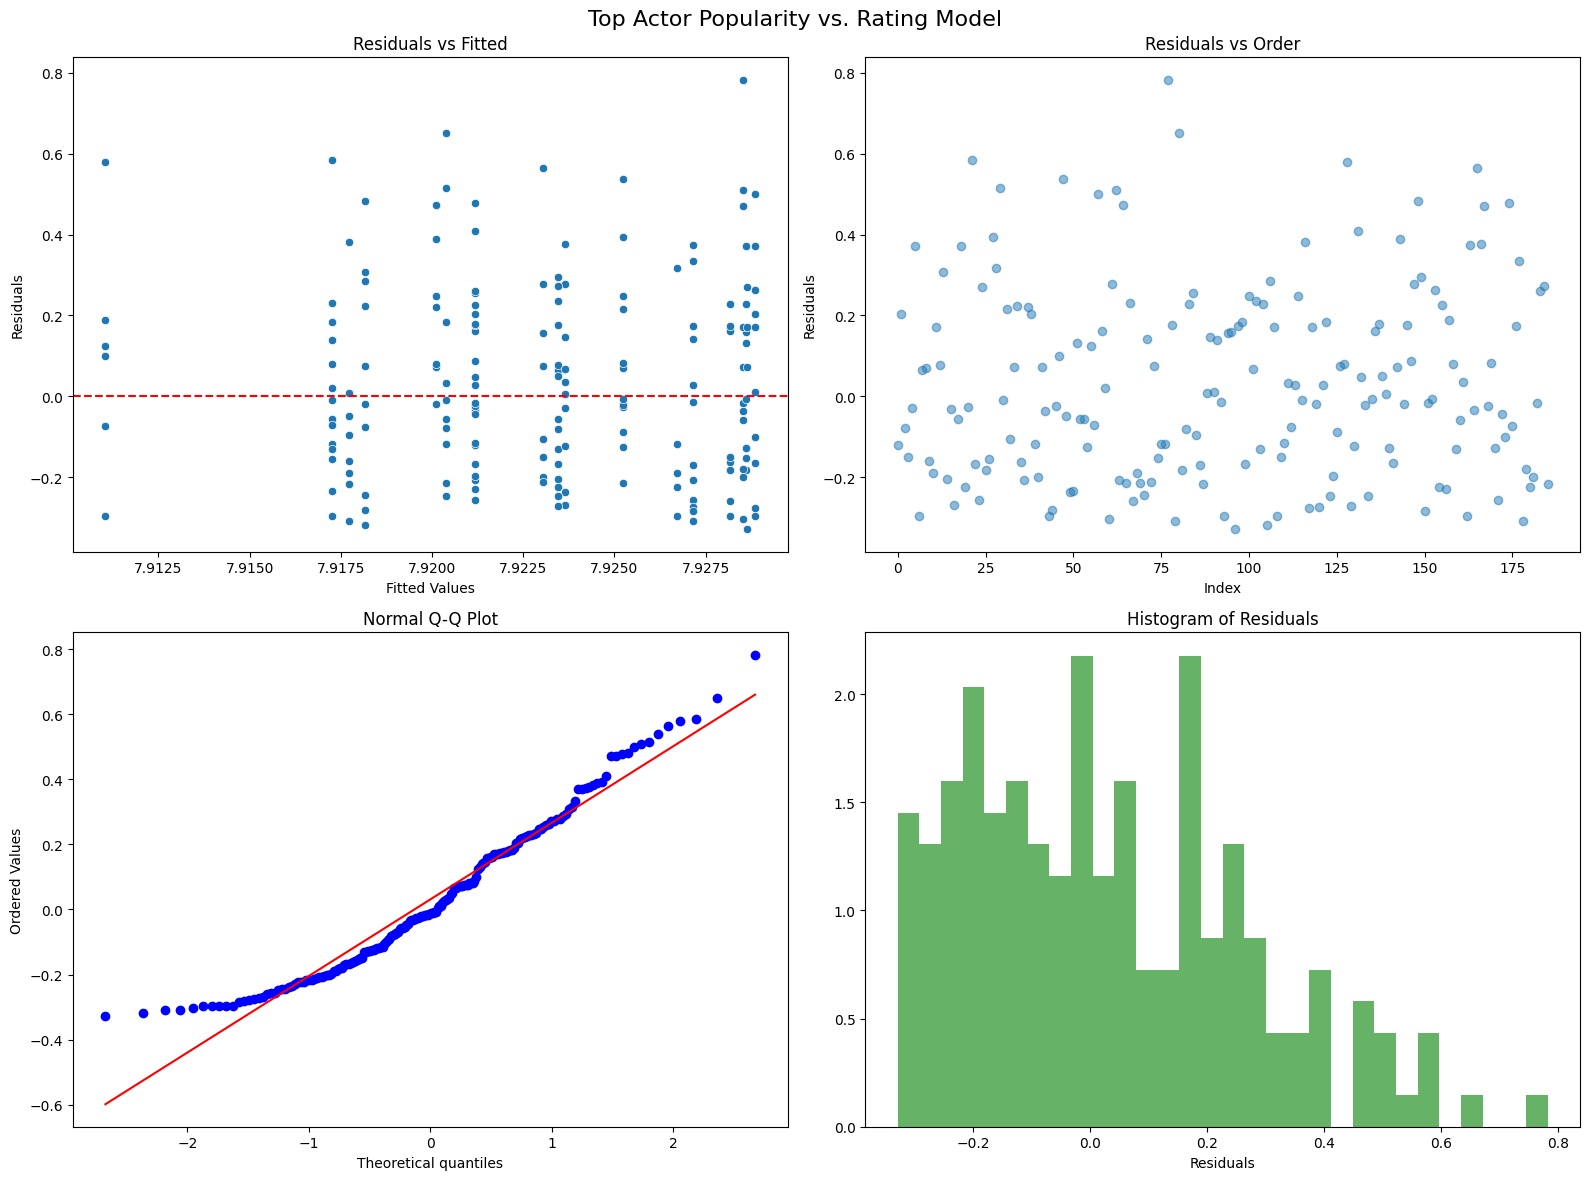


Model 3: Release Year vs. Rating
Release Year vs. Rating Model - Mean Squared Error: 0.05610986643580017
Release Year vs. Rating Model - R2: 0.008396323358058955


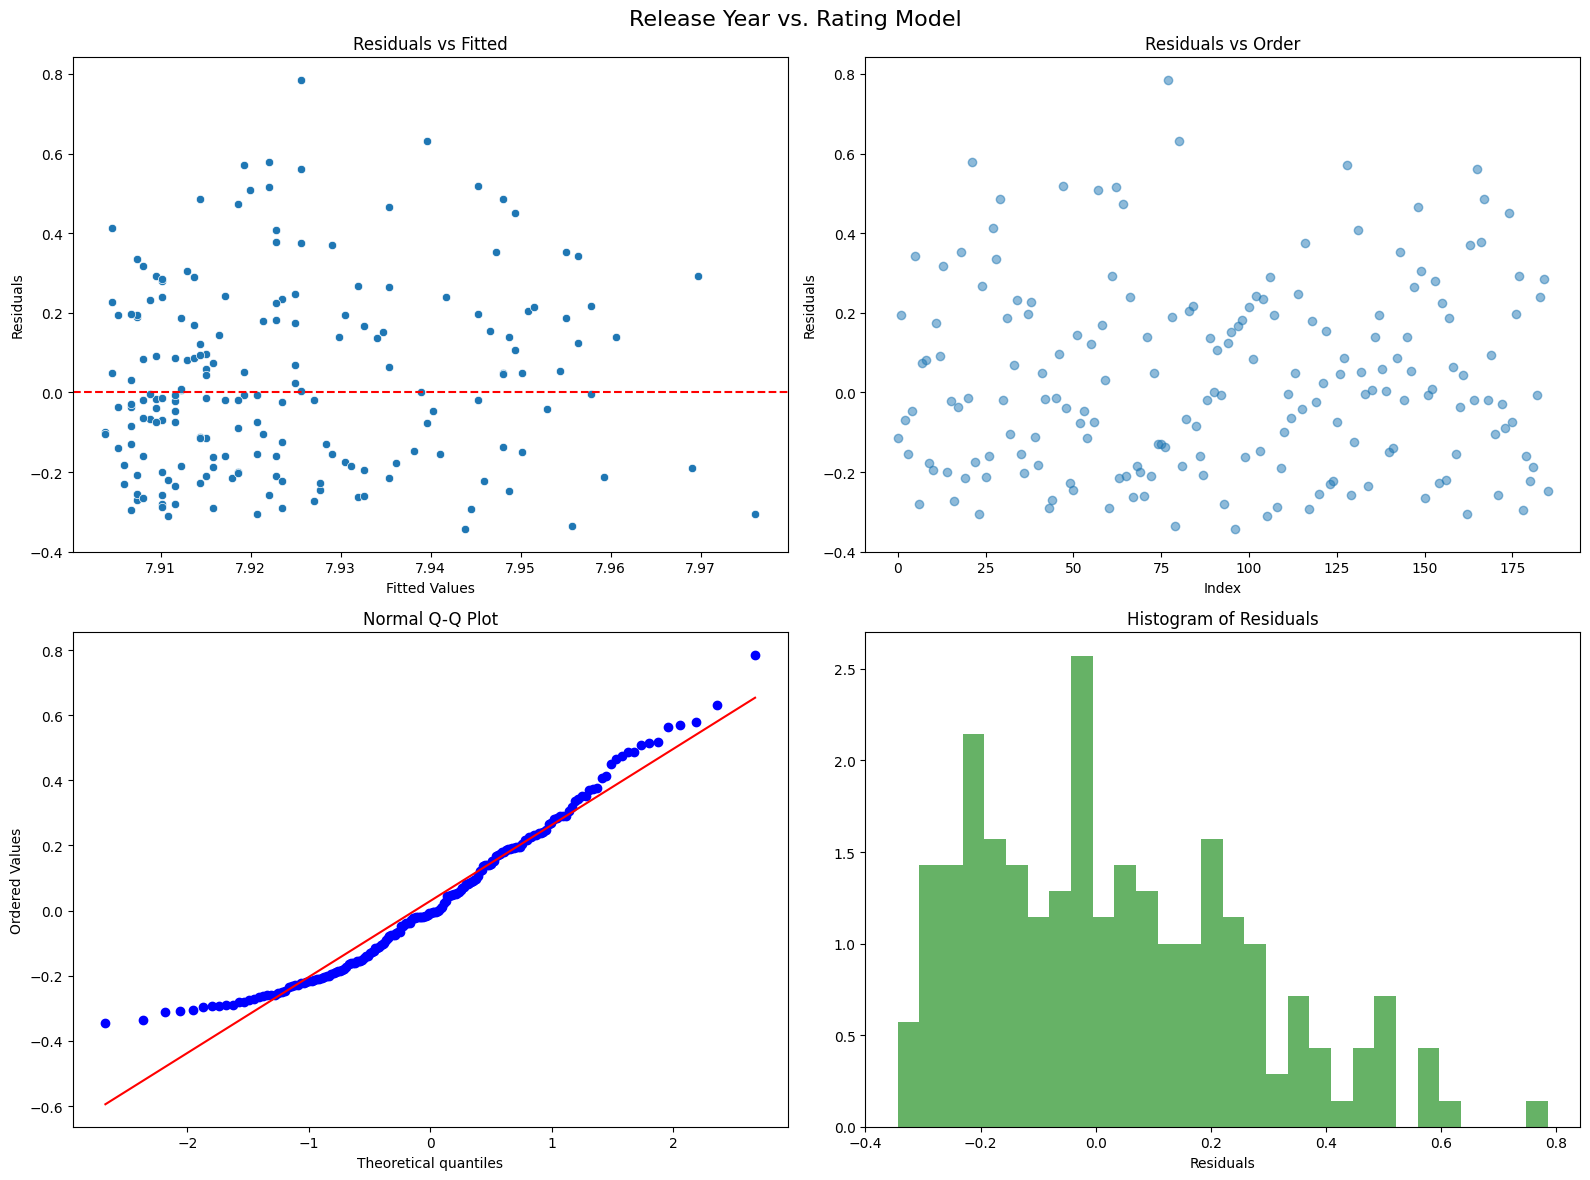


Model 4: Popularity vs. Rating
Popularity vs. Rating Model - Mean Squared Error: 0.11343457180146782
Popularity vs. Rating Model - R2: -1.0046766389176787


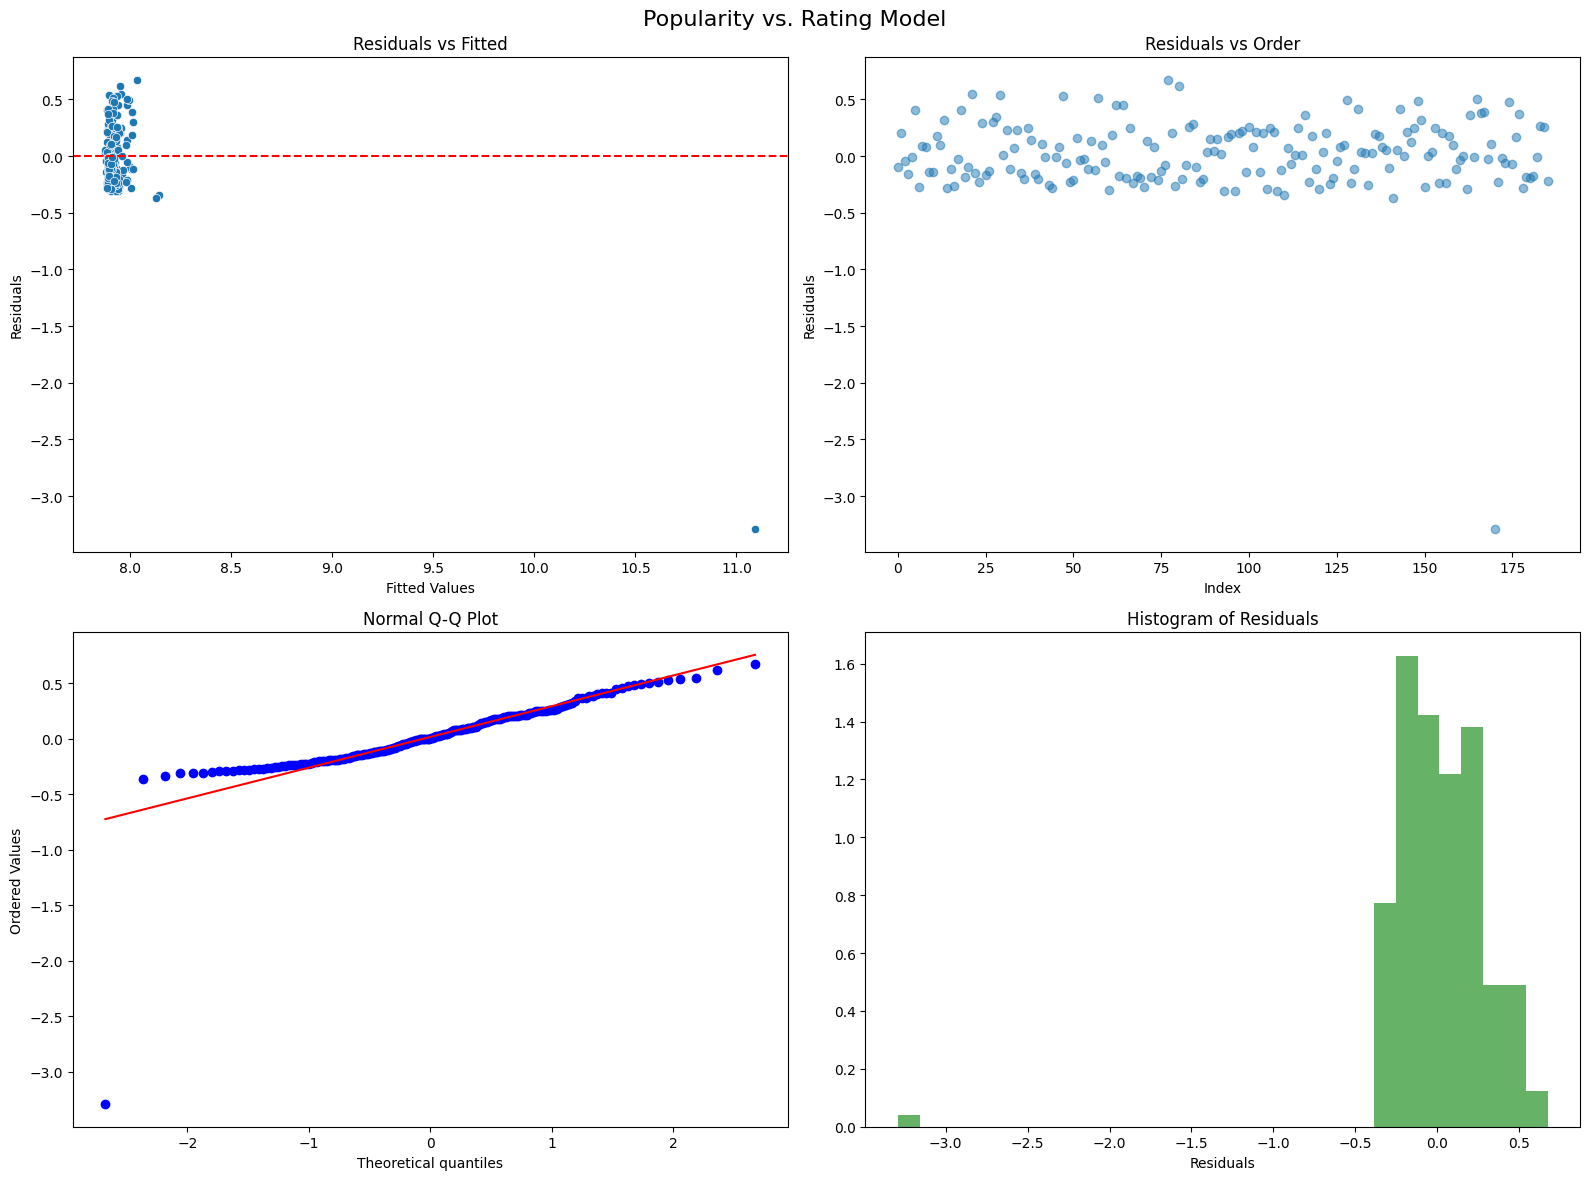


Model 5: Number of Raters vs. Rating
Number of Raters vs. Rating Model - Mean Squared Error: 0.05167327323391623
Number of Raters vs. Rating Model - R2: 0.08680217976455018


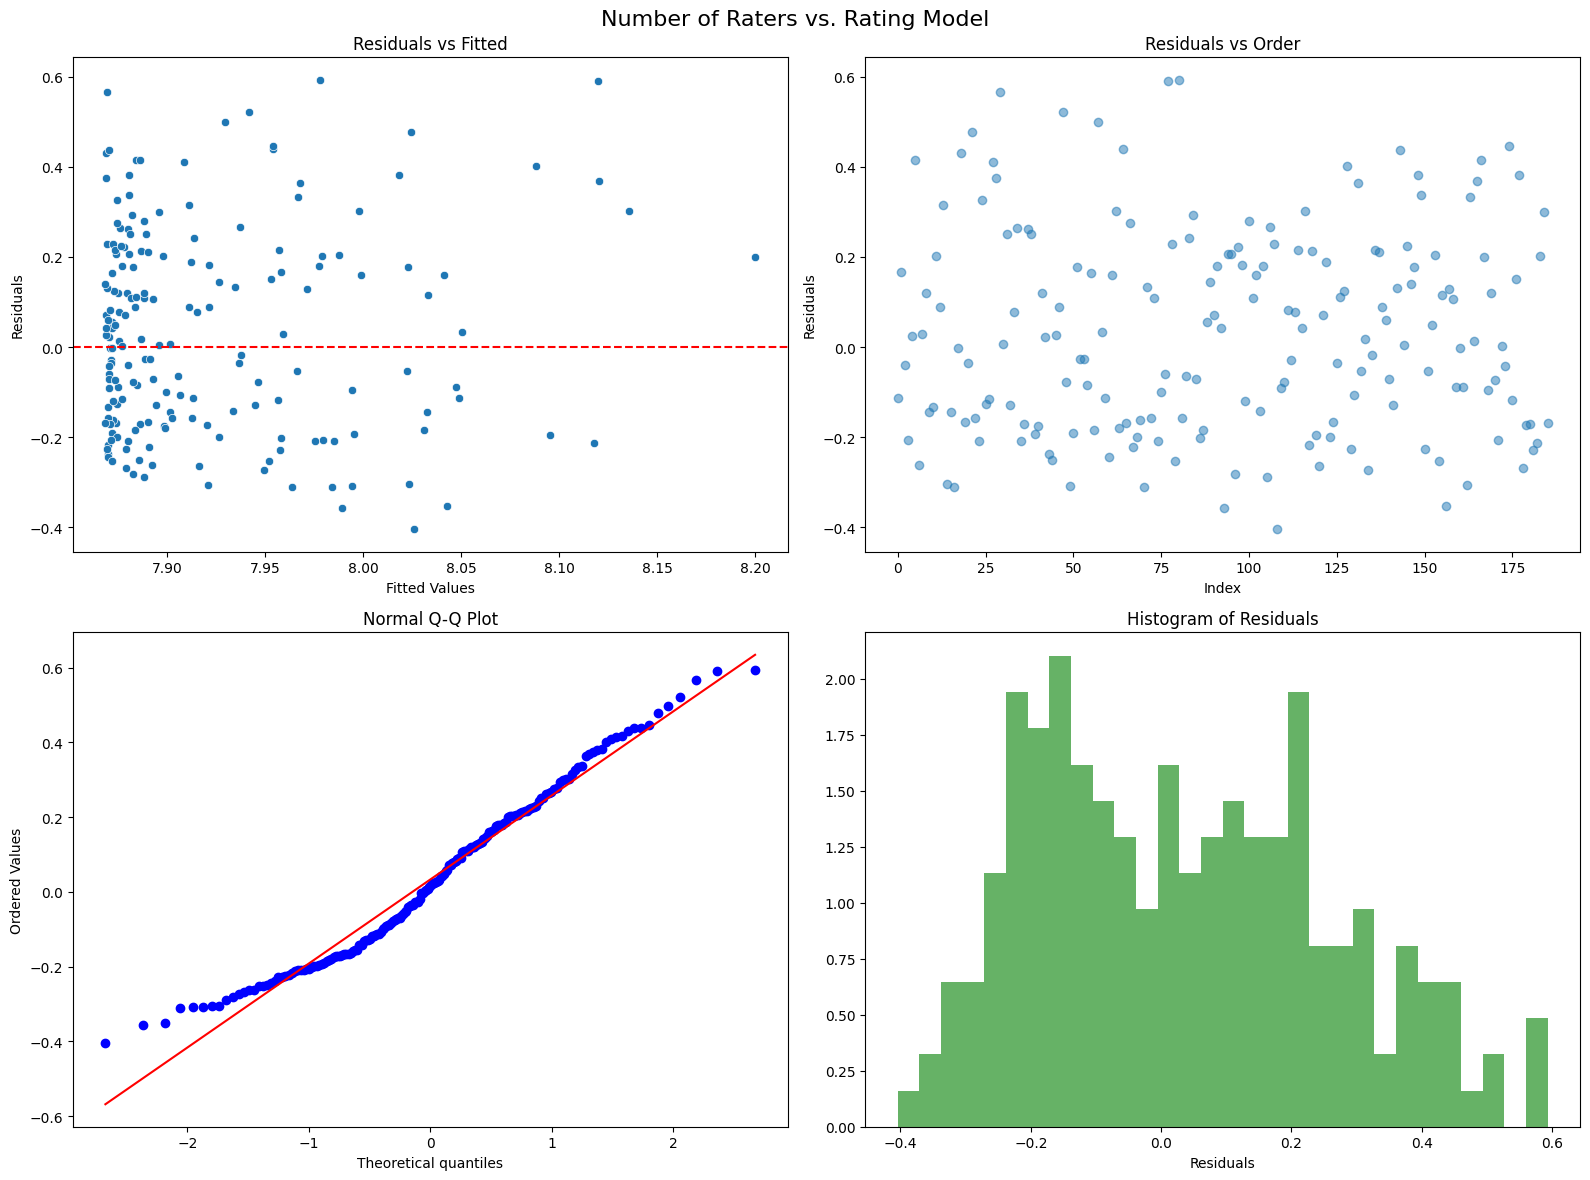


Model 6: Release Month vs. Rating
Release Month vs. Rating Model - Mean Squared Error: 0.05697297865442267
Release Month vs. Rating Model - R2: -0.00685705904519307


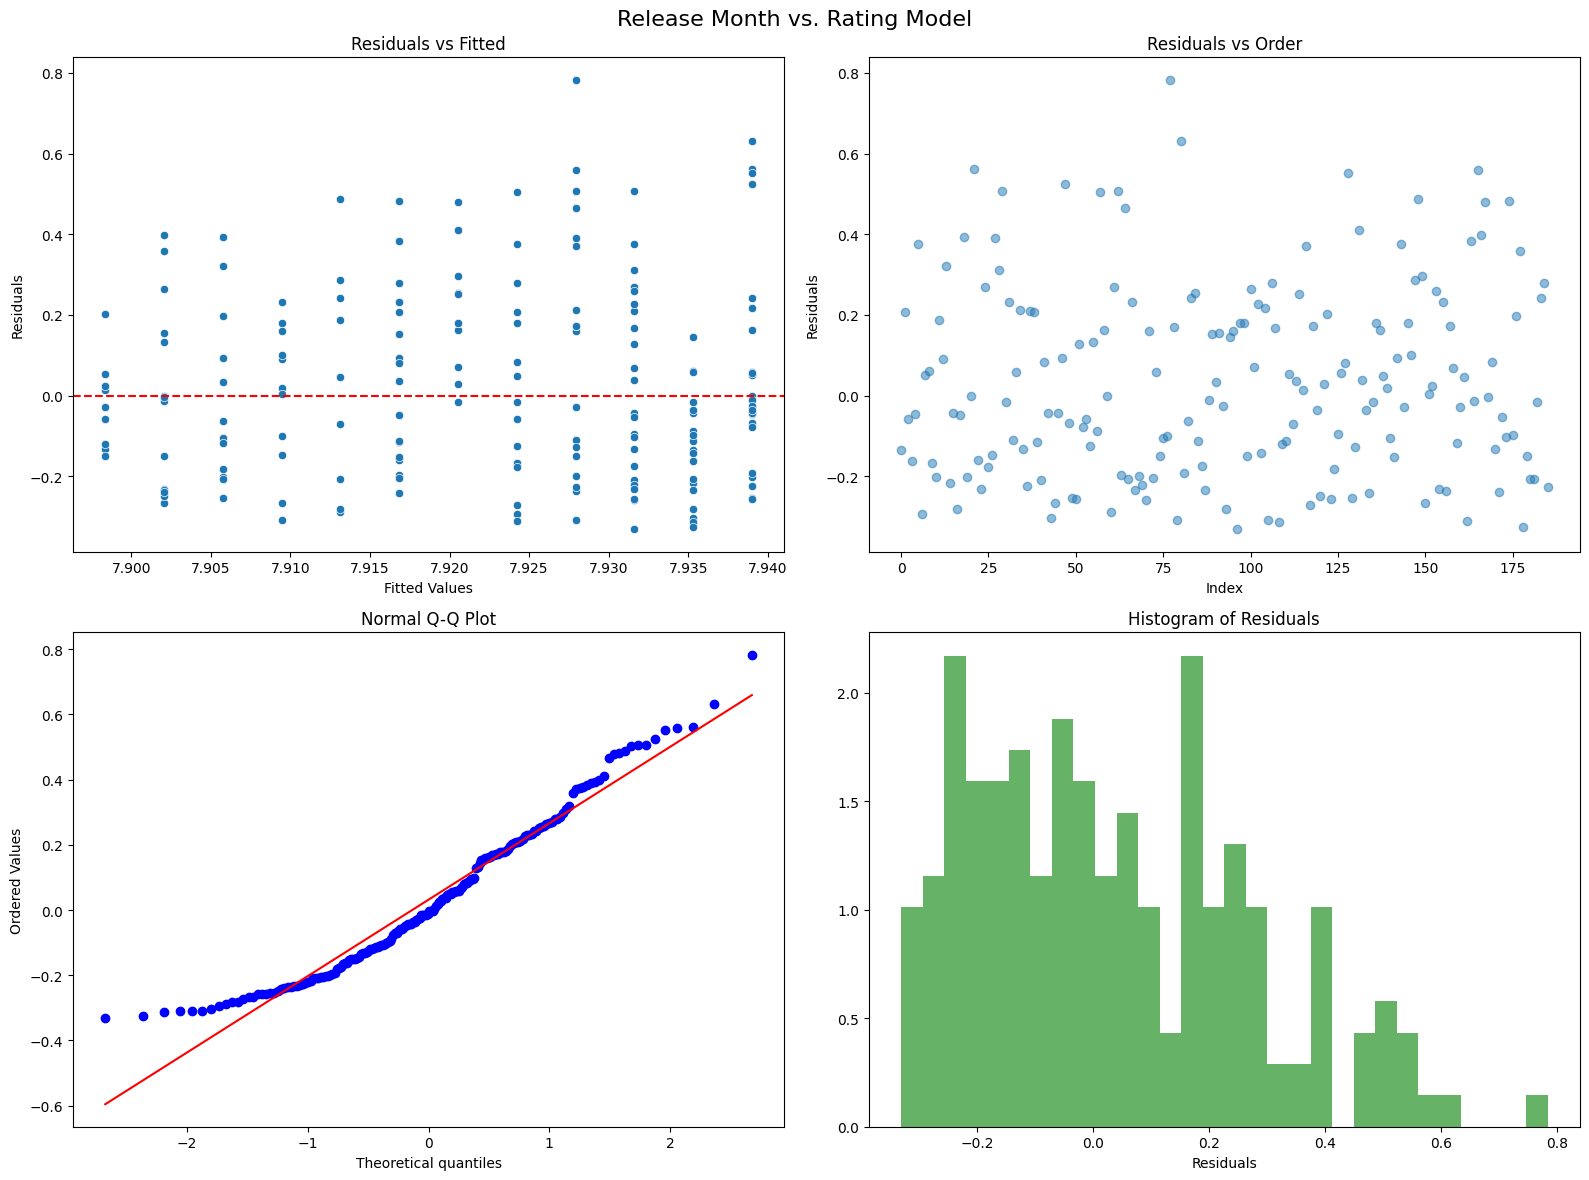

In [6]:
# Function to preprocess the movie data
def preprocess_data(df):
    """
    Preprocess the movie data by keeping only the columns needed
    and ensuring they are numeric.
    
    Args:
        df (pd.DataFrame): original cleaned_df

    Returns:
        df (pd.DataFrame): preprocessed data ready for ML
    """
    required_columns = [
        'rating',
        'budget_in_millions',
        'top_actor_popularity (out of 10)',
        'release_year',
        'popularity',
        'number_of_raters'
    ]
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"Missing columns: {', '.join(missing_columns)}")
    
    # ensure numeric columns are of proper type
    df[['rating', 'budget_in_millions', 'top_actor_popularity (out of 10)', 'release_year', 'popularity', 'number_of_raters']] = df[
        ['rating', 'budget_in_millions', 'top_actor_popularity (out of 10)', 'release_year', 'popularity', 'number_of_raters']].apply(pd.to_numeric, errors='coerce')
    df.dropna(subset=['rating', 'budget_in_millions', 'top_actor_popularity (out of 10)', 'release_year', 'popularity', 'number_of_raters'], inplace=True)
    
    return df


# Function to fit and evaluate the model
def evaluate_model(X, y, title):
    """
    Fit a linear regression model and check assumptions with diagnostic plots.
    
    Args:
        X (array): array with x feature values
        y (array): array with y values
        title (str): title of the model for the graph
    
    Returns:
         An evaluated model for the given feature along with the plots
    """
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Model evaluation
    mse = mean_squared_error(y_test, y_pred)
    print(f"{title} - Mean Squared Error: {mse}")
    r2 = 1 - (mse / y_test.var())
    print(f"{title} - R2: {r2}")

    
    # Residuals
    residuals = y_test - y_pred
    
    # Diagnostic Plots
    plt.figure(figsize=(16, 12))
    
    # 1. Residuals vs Fitted
    plt.subplot(2, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Residuals vs Fitted')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    # 2. Residuals vs Order
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(X_test)), residuals, alpha=0.5)
    plt.xlabel("Index")
    plt.ylabel("Residuals")
    plt.title("Residuals vs Order")
        
    # 3. Q-Q Plot
    plt.subplot(2, 2, 3)
    probplot(residuals, dist="norm", plot=plt)
    plt.title('Normal Q-Q Plot')
    
    # 4. Histogram of Residuals
    plt.subplot(2, 2, 4)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of Residuals')
    plt.xlabel('Residuals')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


# Main function to answer the question
def main():
    """
    Returns:
        Evaluated models for each feature along with the graphs
    """
    df = preprocess_data(cleaned_df)
    
    # budget vs rating
    print("Model 1: Budget vs. Rating")
    X_budget = df[['budget_in_millions']]
    y = df['rating']
    evaluate_model(X_budget, y, "Budget vs. Rating Model")
    
    # top actor popularity vs rating
    print("\nModel 2: Top Actor Popularity vs. Rating")
    X_actor = df[['top_actor_popularity (out of 10)']]
    evaluate_model(X_actor, y, "Top Actor Popularity vs. Rating Model")
    
    # release year vs rating
    print("\nModel 3: Release Year vs. Rating")
    X_year = df[['release_year']]
    evaluate_model(X_year, y, "Release Year vs. Rating Model")
    
    # popularity vs rating
    print("\nModel 4: Popularity vs. Rating")
    X_pop = df[['popularity']]
    evaluate_model(X_pop, y, "Popularity vs. Rating Model")
    
    # num of raters vs rating 
    print("\nModel 5: Number of Raters vs. Rating")
    X_raters = df[['number_of_raters']]
    evaluate_model(X_raters, y, "Number of Raters vs. Rating Model")

    print("\nModel 6: Release Month vs. Rating")
    X_month = df[['release_month']]
    evaluate_model(X_month, y, "Release Month vs. Rating Model")

# Run the main function
if __name__ == '__main__':
    main()

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: trip duration
- $x_1$: time of day
- $x_2$: member or casual (1 or 0)
- $x_3$: electric or classic bike (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## THESE ARE THE EXAMPLES GIVEN!!

## Initial Approach
The initial question we proposed for Machine Learning part is "Can we predict the trip duration based on factors such as the time of day, user demographics, and starting/ending stations?", and after further discussions and analysis, we identified we can try building the models based on a Linear Regression for 3 features separately and a Polynomial Regression for one of the features. However, as we moved forward in with the Linear Regression analysis, we got unexpectedly large values for both $MSE$ and $R^2$ for all 3 features. This made us reconsider our initial attempt and go with Polynomial Regression for one of the features (Time of Day). After constructing the model equation and using cross-validation, we received values of $MSE$ = 627.869 and $R^2$ = 0.0035, which showed worse results, compared to Linear Regression. Therefore, we decided to fix our model by incorporating interactions with dummy variables (member_casual and rideable_type), which had values of 1 and 0. Building the polynomial regression model with interactions and dummy variables has slighly improved the $MSE$ = 599.699 and $R^2$ = 0.0482. However, the values were still significantly worse, than the Linear Regression model's ones. Therefore, we we will use the Linear Regression model to discuss the preliminary results.

## Model 1
First, we analyzed Model 1: Time of Day of Linear Regression model. We calculated $MSE$ = 514.094 and $R^2$ = 0.0477, where MSE value is lower than for the polynomial regression models and $R^2$ value is slightly lower than the second polynomial regression model. Based on the first plot of Residuals vs Fitted, we can see that the assumption of Linearity and Constant Variance is violated as the residuals do not follow a linear trend about 0 and also contain multiple outliers. The second plot of Residuals vs Order shows that there is some density of the data points near the y = 0 with mutliple outliers as well, indicating there might be a violation of Independence assumption as well. Looking at the Histogram of Residuals and Q-q plot, we can witness there is strong right-skewedness, showing that there is no normal distribution, meaning violation of Normality assumption. 

## Model 2
Second, we analyzed Model 2: User Demographics of Linear Regression Model. Calculating $MSE$ = 508.001 and $R^2$ = 0.059 shows that this is the highest values we were able to identify. There is a violation of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, data points are not equally distributed around y=0 line, they have significant gaps between vertical line patterns of the data points. Moreover, the Independence assumption might be violated due to the density above y = 0 line. Finally, we see that the residuals are right skewed on Q-Q plot and Histogram of residuals. Therefore, the plots also violate the assumptions, despite better looking values.

## Model 3
Finally, the last Model 3: Starting and Ending Stations has $MSE$ = 514.076 and $R^2$ = 0.0478, the values are somewhat similar to the ones from Model 1. The model also fails to meet the assumptions of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, data points are not distributed closer to y=0 line, have occasional gaps and outliers. Moreover, the Independence assumption might be violated due to the density above y = 0 line. Finally, we see that the residuals are right skewed on Q-Q plot and Histogram of residuals. 

## Conclusions
These findings paint a complex picture of the bike-sharing prediction challenge. While Linear Regression provided our best results among the attempted approaches, the consistent violations of key assumptions across all models reveal fundamental challenges in our modeling strategy. 

First, the pervasive violations of regression assumptions across all models suggest systemic issues in how we're approaching the prediction task. The violation of linearity assumptions, evidenced by clear patterns in our residual plots, indicates that the relationship between our predictors and trip duration isn't as straightforward as our models assume. For instance, the impact of time of day on trip duration might follow a more complex pattern influenced by rush hours, weekends, or seasonal effects that our linear approach can't capture. Similarly, the relationship between station locations and trip duration might be influenced by geographic features, traffic patterns, or neighborhood characteristics that require more sophisticated modeling approaches.

The heteroscedasticity observed in our models (non-constant variance in residuals) suggests that our predictions' accuracy varies significantly across different conditions. This could indicate that trip durations are more predictable in some circumstances than others – perhaps more consistent during regular commuting hours but more variable during leisure times. This varying predictability challenges our model's ability to provide reliable estimates across all scenarios.

The notably low R² values (ranging from 0.0477 to 0.059) are particularly telling. These values indicate that our models explain less than 6% of the variance in trip durations, leaving over 94% of the variation unexplained. This substantial unexplained variance could stem from several sources, such as missing key features, complex interaction, or hidden variables.

Future research directions might include:
- Exploring more sophisticated modeling techniques such as mixed-effects models to account for hierarchical structure in the data
- Investigating even more additional features that might better explain trip duration variability
- Considering non-parametric approaches that don't rely on the strict assumptions of linear regression
- Implementing geospatial modeling techniques to better capture the impact of station locations

 Understanding these limitations and potential improvements is crucial for developing more effective prediction models in future iterations. The complexity revealed by our analysis suggests that successful trip duration prediction might require a more nuanced, multi-model approach that can adapt to different conditions and user patterns. Our results demonstrate the challenges of real-world predictive modeling and the importance of thorough diagnostic testing, even when working with seemingly straightforward prediction tasks.